In [60]:
import tensorflow as tf
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from sklearn import metrics
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams

In [61]:
data1 = pd.read_csv('./CIC_RF_train.csv')
data2 = pd.read_csv('./CIC_RF_test.csv')

X_train = data1.iloc[:,:-1]
y_train = data1.iloc[:,-1]
X_test = data2.iloc[:,:-1]
y_test = data2.iloc[:,-1]

X_train

,Flow Duration,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Packets/s,...,Packet Length Variance,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Bytes,act_data_pkt_fwd,Idle Mean,Idle Max,Idle Min
0,1.662912e-02,0.001239,0.038235,0.000000,0.046698,0.058258,0.048490,0.041336,0.056495,0.400001,...,0.006489,0.000000,0.076599,0.046698,0.041336,0.001239,0.000015,0.000000,0.000000,0.000000
1,9.857595e-01,0.001068,0.020830,0.000000,0.016567,0.020747,0.048592,0.038924,0.046349,0.400000,...,0.002909,0.000000,0.046742,0.016567,0.038924,0.001068,0.000081,0.490000,0.490833,0.490000
2,9.805423e-01,0.002285,0.044803,0.000000,0.033484,0.047432,0.071582,0.085773,0.076203,0.400000,...,0.009554,0.023256,0.101508,0.033484,0.085773,0.002285,0.000041,0.489167,0.491667,0.487500
3,4.166667e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,8.198974e-01,0.000280,0.013820,0.000000,0.012318,0.021780,0.296569,0.442150,0.324761,0.400000,...,0.155027,0.023256,0.380870,0.012318,0.442150,0.000280,0.000005,0.820000,0.820000,0.820000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414837,4.166667e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
414838,3.333333e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.533333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
414839,5.632634e-01,0.000297,0.013658,0.000000,0.011174,0.019699,0.222427,0.442150,0.261301,0.400000,...,0.112128,0.000000,0.352338,0.011174,0.442150,0.000297,0.000020,0.561667,0.561667,0.561667
414840,4.667481e-02,0.000519,0.020830,0.000000,0.019547,0.029663,0.008039,0.008980,0.011689,0.400000,...,0.001188,0.000000,0.027565,0.019547,0.008980,0.000519,0.000015,0.044380,0.044380,0.044380


# DNN

In [29]:
batch_size = 64

model = Sequential()
model.add(Dense(1024, input_dim=34, activation='relu'))
model.add(Dropout(0.01))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=batch_size, nb_epoch=100)

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
182720/414842 [============>.................] - ETA: 6s - loss: 0.1642 - accuracy: 0.9328

KeyboardInterrupt: 

In [20]:
predictions = model.predict_classes(X_test)

# res = metrics.classification_report(y_test,result)
# print(res)

mse = np.mean(np.power(X_test - predictions,2),axis=1)
error_df = pd.DataFrame({'reconstruction_error':mse, 'true_class':y_test})

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['true_class'], error_df['reconstruction_error'])

In [21]:
# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
# threshold_fixed = 4.526054e-07 
print('threshold: ',threshold_fixed)

precision:  0.919495481179859 , recall:  0.919495481179859
threshold:  0.01541768977468511


C:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


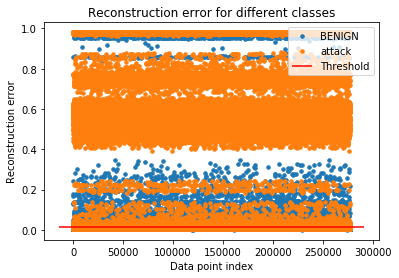

0.01541768977468511


In [22]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "attack" if name ==1 else "BENIGN")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()
print(threshold_fixed)

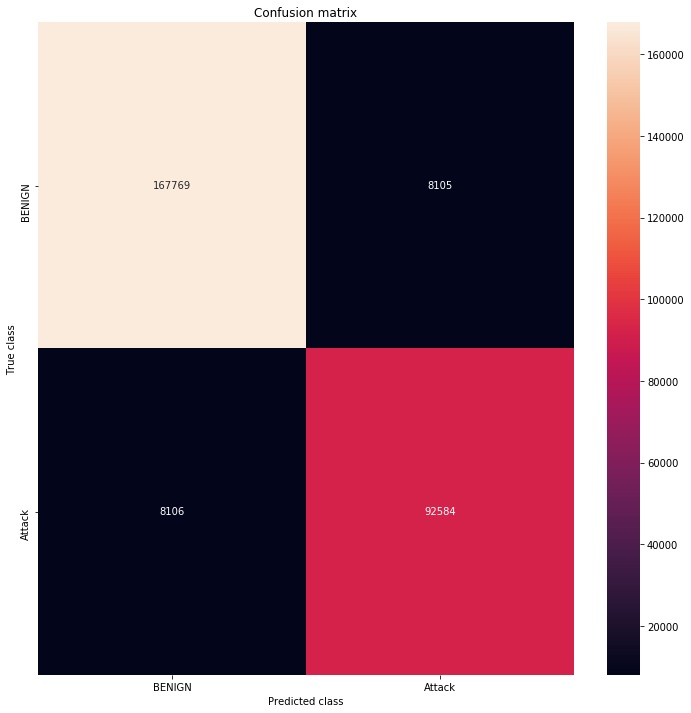

In [24]:
#threshold = 0.0001
LABELS=["BENIGN","Attack"]
y_pred = [1 if e > threshold_fixed else 0 for e in error_df.reconstruction_error.values]
conf_matrix = metrics.confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Kmeans-Clustering

In [79]:
#import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans

In [80]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train,y_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [81]:
result=kmeans.predict(X_test)

In [82]:
res = metrics.classification_report(y_test,result)
print(res)

              precision    recall  f1-score   support

         0.0       0.78      0.99      0.88    175874
         1.0       0.97      0.52      0.68    100690

    accuracy                           0.82    276564
   macro avg       0.88      0.76      0.78    276564
weighted avg       0.85      0.82      0.80    276564



# DBSCAN

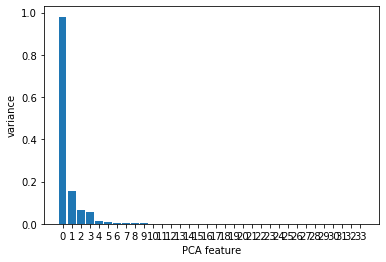

In [73]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

features = range(pca.n_components_)
plt.bar(features,pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [76]:
pca = PCA(n_components=5)
pca_features = pca.fit_transform(X_train)

In [85]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

data1 = pd.read_csv('./CIC_normX_train.csv')
data2 = pd.read_csv('./CIC_normX_test.csv')

X_train = data1.iloc[:,:-1]
y_train = data1.iloc[:,-1]
X_test = data2.iloc[:,:-1]
y_test = data2.iloc[:,-1]

scaler = StandardScaler().fit(X_train)
x_scaled_ss = scaler.transform(X_train)

dbscan = DBSCAN(eps=3,min_samples=5).fit_predict(x_scaled_ss)

TypeError: __init__() missing 2 required positional arguments: 'shape' and 'dtype'